 <font size="6"><p style="text-align:center"><b> Прогнозирование заказов компании "Чётенькое такси" </b></p></font>

<div class="alert alert-dan
            ger">
<font size="4"><b>План:</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные находятся в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

<font size="5"><p style="text-align:center"><b> ***Шаг 1. Обзор и подготовка данных*** </b></p></font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (21,14)
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from catboost import CatBoostRegressor

In [2]:
try:
    data = pd.read_csv('C:/Users/Asus/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


26 496 строк, показывающих количество заказов такси в аэропорту каждые 10 минут в течение полугода с 1-го марта 2018-го года по 31-е августа 2018-го года.

Выполним ресемплирование по 1 часу.

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

<font size="5"><p style="text-align:center"><b> ***Шаг 2. Анализ данных*** </b></p></font>

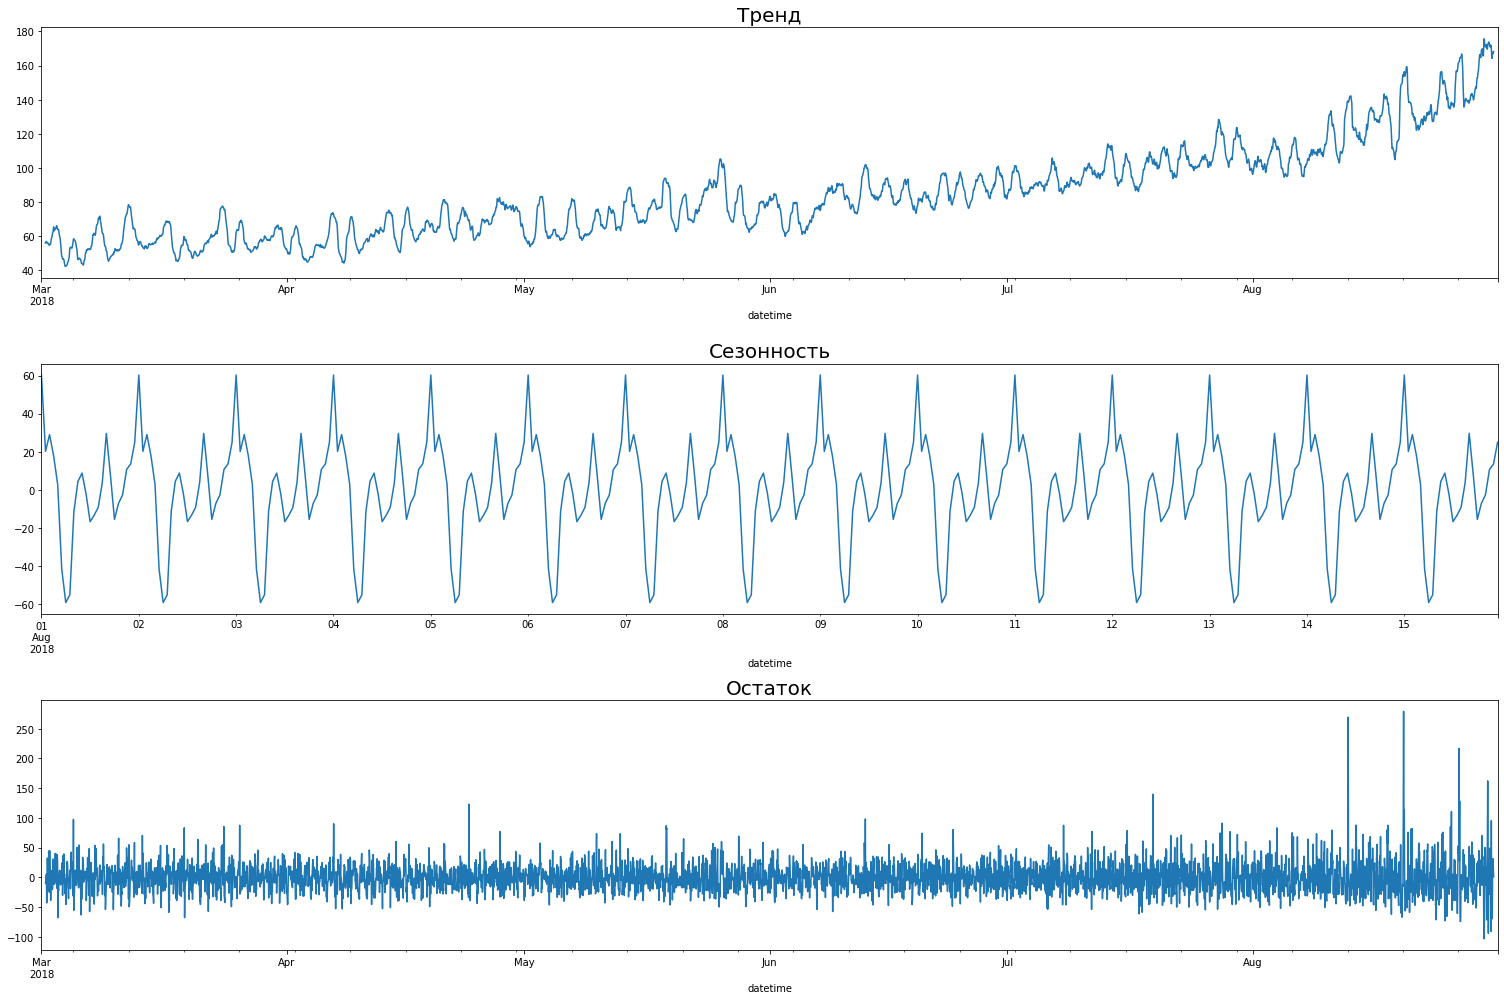

In [5]:
decomposed = seasonal_decompose(data)

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд', fontsize = 20)
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Сезонность', fontsize = 20)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток', fontsize = 20)
plt.tight_layout()

Тренд на увеличение заказов к летнему периоду, что логично. 

Создадим признаки для горизонта прогнозирования в один шаг.

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = data.index.year
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

data = make_features(data, 25, 5)

<font size="5"><p style="text-align:center"><b> ***Шаг 3. Обучение моделей*** </b></p></font>

Разделим данные на выборки.

In [7]:
train, valid = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)

print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-02 01:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Отделим признаки и таргет.

In [8]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)

target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

Определим более важные для модели признаки.

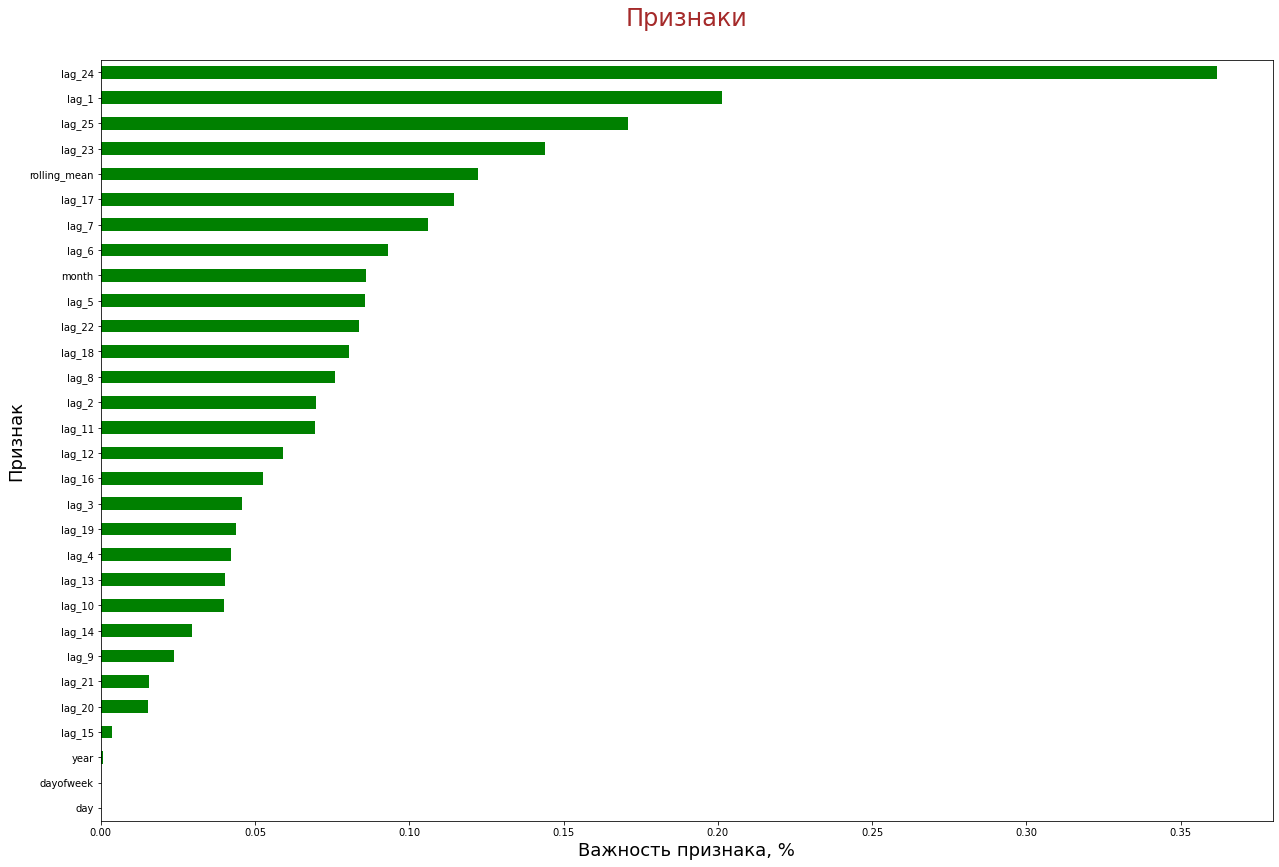

In [9]:
features = pd.DataFrame(features_train)
X = features
y = target_train
importances = mutual_info_regression(X=X, y=y) 
feature_importances = pd.Series(importances, X.columns).sort_values()
feature_importances.plot(kind='barh', color='green').set_title('Признаки' + "\n", fontsize = 24, color = 'brown')
plt.xlabel('Важность признака, %', fontsize = 18)
plt.ylabel("Признак", fontsize = 18)
plt.show;

Удалим неинформативные для модели признаки (день, день недели и год).

In [10]:
features_train = features_train.drop(['day', 'year', 'dayofweek'], axis=1) 
features_valid = features_valid.drop(['day', 'year', 'dayofweek'], axis=1) 
features_test = features_test.drop(['day', 'year', 'dayofweek'], axis=1) 

Выполним масштабирование признаков.

In [11]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train))
features_valid = pd.DataFrame(scaler.transform(features_valid))
features_test = pd.DataFrame(scaler.transform(features_test))

Обучим модель линейной регрессии, чтобы подобрать более правильные признаки ширины окна и размера отставания, оценивая RMSE.

In [12]:
model = LinearRegression().fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print("RMSE обучающей выборки:", mean_squared_error(target_train, pred_train) ** 0.5)
print("RMSE валидационной выборки: ", mean_squared_error(target_valid, pred_valid) ** 0.5)

RMSE обучающей выборки: 24.59913736166941
RMSE валидационной выборки:  34.22407326743578


In [13]:
parameters = {'max_depth': range(2, 15), 'n_estimators': range(10, 90, 10)}

model = RandomForestRegressor(random_state=12345)

metrics = ['neg_root_mean_squared_error']
tscv = TimeSeriesSplit(n_splits=5)
search = GridSearchCV(model, parameters, cv=tscv, scoring=metrics, refit='neg_root_mean_squared_error')
search.fit(features_train, target_train)
results = search.cv_results_

print('RMSE on VALID:', '%.4f' %-(search.best_score_))
print(pd.Series(search.best_params_))

RMSE on VALID: 24.4216
max_depth       13
n_estimators    70
dtype: int64


In [14]:
model_cat = CatBoostRegressor(loss_function="RMSE", learning_rate=0.1, iterations=200)

model_cat.fit(features_train, target_train, verbose=10)

pred_valid = model_cat.predict(features_valid) 
print("Valid RMSE: %.2f"%mean_squared_error(target_valid, pred_valid) ** 0.5)

0:	learn: 34.2568001	total: 55.7ms	remaining: 11.1s
10:	learn: 25.9138418	total: 126ms	remaining: 2.17s
20:	learn: 23.2185834	total: 206ms	remaining: 1.76s
30:	learn: 22.0484541	total: 284ms	remaining: 1.55s
40:	learn: 21.3194048	total: 372ms	remaining: 1.44s
50:	learn: 20.7171953	total: 473ms	remaining: 1.38s
60:	learn: 20.2378156	total: 561ms	remaining: 1.28s
70:	learn: 19.8447617	total: 643ms	remaining: 1.17s
80:	learn: 19.4198706	total: 724ms	remaining: 1.06s
90:	learn: 19.0353444	total: 803ms	remaining: 961ms
100:	learn: 18.6805670	total: 876ms	remaining: 858ms
110:	learn: 18.3749943	total: 944ms	remaining: 757ms
120:	learn: 17.9409916	total: 1.02s	remaining: 664ms
130:	learn: 17.5417688	total: 1.09s	remaining: 575ms
140:	learn: 17.1839308	total: 1.18s	remaining: 493ms
150:	learn: 16.9301265	total: 1.25s	remaining: 406ms
160:	learn: 16.6757227	total: 1.33s	remaining: 322ms
170:	learn: 16.3569700	total: 1.4s	remaining: 238ms
180:	learn: 16.2005664	total: 1.48s	remaining: 155ms
190:

Лучшей моделью оказался случайный лес - RMSE 24 на валидации.

<font size="5"><p style="text-align:center"><b> ***Шаг 4. Тестирование модели*** </b></p></font>

In [15]:
model = RandomForestRegressor(random_state=12345, max_depth=13, n_estimators=70)
pred_test = model.fit(features_train, target_train).predict(features_test) 
print("Test RMSE RF: %.2f"%mean_squared_error(target_test, pred_test) ** 0.5)

Test RMSE RF: 49.69


Попробуем конкатенировать выборки и дообучить модель.

In [16]:
features = pd.concat([features_train, features_valid])
target = pd.concat([target_train, target_valid])

model = RandomForestRegressor(random_state=12345, max_depth=13, n_estimators=70)
pred_test = model.fit(features, target).predict(features_test) 
print("Test RMSE RF: %.2f"%mean_squared_error(target_test, pred_test) ** 0.5)

Test RMSE RF: 43.38


Дообучение улучшило метрику.

Визулизируем исходный и предсказанный ряды.

In [18]:
pred_test = pd.DataFrame(pred_test, index=target_test.index)

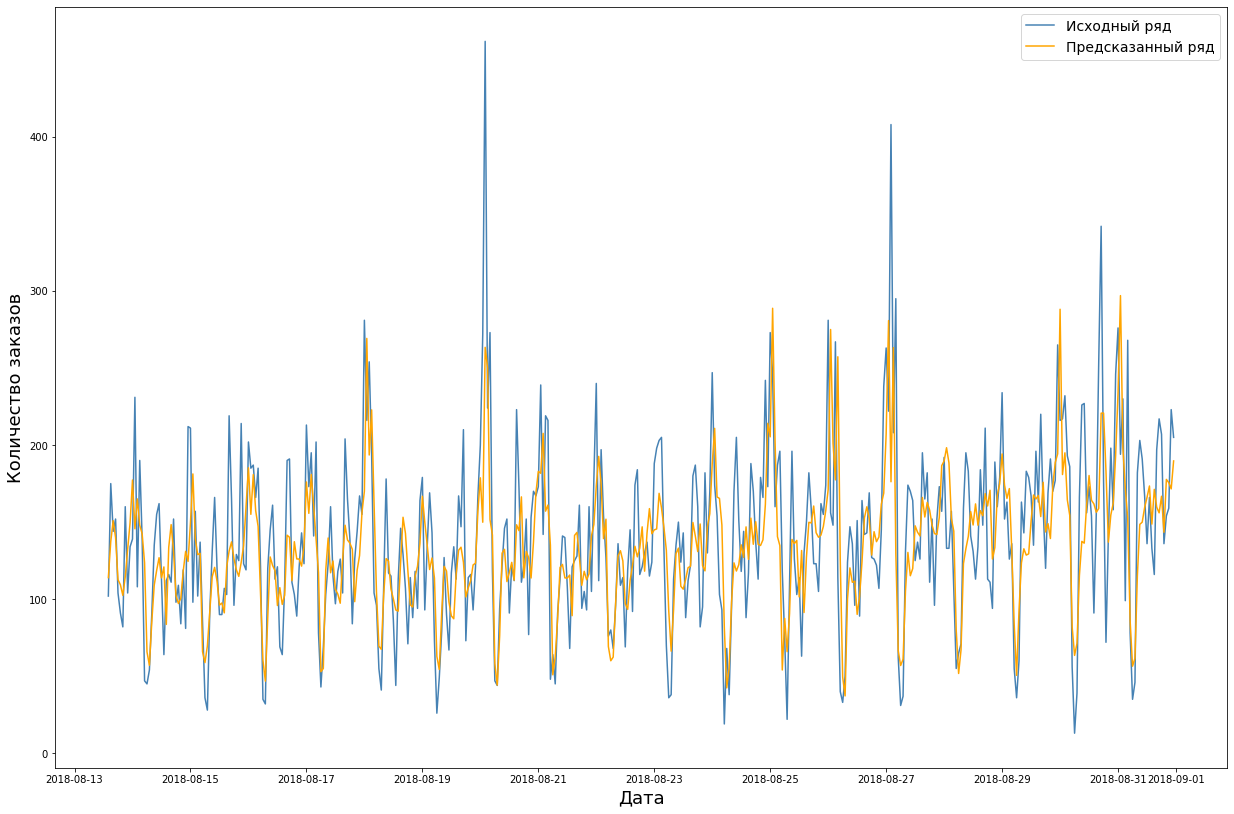

In [20]:
plt.plot(target_test, label='Исходный ряд', color='steelblue')
plt.plot(pred_test, label='Предсказанный ряд', color='orange')

plt.legend(fontsize=14)
plt.xlabel('Дата', fontsize = 18)
plt.ylabel("Количество заказов", fontsize = 18)

plt.show()

<font size="5"><p style="text-align:center"><b> ***Вывод*** </b></p></font>

Компании «Чётенькое такси» нужно спрогнозировать количество заказов такси на следующий час. Для постройки модели для такого предсказания мы:
- загрузили данные и выполнили их ресемплирование по одному часу.
- проанализировали данные.
- обучили разные модели с различными гиперпараметрами. Сделали тестовую выборку размером 10% от исходных данных.
- проверили данные на тестовой выборке. 

Лучшую метрику качества RMSE (43) показала модель - случайный лес.